In [94]:
from numba import jit
import numpy as np
from numba import jit, int32, float32, types, typed
from numba.typed import List
from numba.experimental import jitclass
import matplotlib.pyplot as plt

In [208]:
gyro_radius = 3.086*10**17 # 10 PeV proton in 1 mucro Gauss B field
steps_per_gyration = 10
c = 3*10**8

In [209]:
@jit(nopython=True, fastmath=True)
def propagate(particle_id, spheres):
    pos = [0.0, 0.0, 0.0]
    phi = 0.0
    particle_info = []
    direction = [1,1,1]
    isotrop = False
    
    for i in range(1,10**5): 
        pos_prev = pos
        
        ### change direction #############################################################
        if np.random.random() < 0.002:
            direction[0] = -1*direction[0]
        if np.random.random() < 0.003:
            direction[1] = -1*direction[1]
        if np.random.random() < 0.003:
            direction[2] = -1*direction[2]
            
        ### move in updated direction ####################################################
        if isotrop:
            normalize = (direction[0]**2+direction[1]**2+direction[2]**2)**0.5
            time = i # ToDo change this (need to incooperate steplength)
            for j in range(3):
                pos[j] = pos[j] + direction[j]/normalize
        else:
            phi_old = phi
            phi = phi_old + 2 * np.pi / steps_per_gyration
            ### move in phi direction 
            ### distance_traveled = 2*pi*gyro_radius / steps_per_gyration
            delta_x = gyro_radius * (np.cos(phi) - np.cos(phi_old)) * direction[0]
            delta_y = gyro_radius * (np.sin(phi) - np.sin(phi_old)) * direction[0]
            ### move in rho direction
            ### distance_traveled = 2*pi*gyro_radius / steps_per_gyration
            delta_x = delta_x + np.cos(phi) * gyro_radius * direction[1] * 2 * np.pi / steps_per_gyration
            delta_y = delta_y + np.sin(phi) * gyro_radius * direction[1] * 2 * np.pi / steps_per_gyration
            ### move in z direction
            delta_z = direction[2] * 2 * np.pi * gyro_radius / steps_per_gyration
            ### move !!!
            pos[0] = pos[0] + delta_x
            pos[1] = pos[1] + delta_y
            pos[2] = pos[2] + delta_z
            ### distance_travelled
            distance = 3 * 2*pi*gyro_radius / steps_per_gyration
            time = time + distance

        
        ### observer ####################################################################
        r2_prev = pos_prev[0]**2+pos_prev[1]**2+pos_prev[2]**2
        r2 = pos[0]**2+pos[1]**2+pos[2]**2
        if i<1000 or i%500 == 0:
            particle_info.append([particle_id, time, pos[0], pos[1], pos[2], -1.0])
        for r2_sphere in spheres:
            if r2_prev > r2_sphere and r2 <= r2_sphere or r2_prev < r2_sphere and r2 >= r2_sphere:
                particle_info.append([particle_id, time, pos[0], pos[1], pos[2], r2_sphere*1.0])
        
    return particle_info

In [210]:
@jit(nopython=True)
def many_particles(observer_spheres):
    data = [[0.0, 0.0, 0.0, 0.0, -1.0]]
    for i in range(10**2):
        particle_id = i
        data_new = propagate(particle_id, observer_spheres)
        data = data + data_new

    print('finished')
    return data

In [211]:
observer_spheres = np.array([-1.0]) 
%time data = many_particles(observer_spheres)

finished
Wall time: 4.76 s


In [212]:
import pandas as pd
df = pd.DataFrame(data[1:])
df.columns = ['id', 't', 'x', 'y', 'z', 'radius']
df

,id,t,x,y,z,radius
0,0.0,0.1,9.793031e+16,2.953616e+17,1.938991e+17,-1.0
1,0.0,0.2,3.548427e+15,5.918761e+17,3.877982e+17,-1.0
2,0.0,0.3,-2.470950e+17,7.762851e+17,5.816973e+17,-1.0
3,0.0,0.4,-5.582626e+17,7.781506e+17,7.755964e+17,-1.0
4,0.0,0.5,-8.110991e+17,5.967601e+17,9.694955e+17,-1.0
...,...,...,...,...,...,...
119695,99.0,9750.0,1.060478e+19,1.603450e+18,1.617894e+21,-1.0
119696,99.0,9800.0,1.090704e+19,2.553223e+18,1.577563e+21,-1.0
119697,99.0,9850.0,9.583166e+18,2.309476e+18,1.607811e+21,-1.0
119698,99.0,9900.0,6.945699e+18,1.583914e+18,1.510862e+21,-1.0


In [213]:
# remove duplicated elements from list of times 
times = []
[times.append(t) for t in df['t'] if t not in times]
kappa_perp = []
kappa_para = []
for t in times:
    df_t = df.loc[df['t'] ==  t] # number of gyrations
    kappa_perp.append(np.mean((df_t['x'].values**2+df_t['y'].values**2))/(4*t))
    kappa_para.append(np.mean(df_t['z'].values**2)/(2*t))

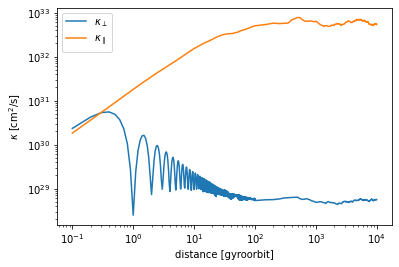

In [214]:
from modules.Plotter import Plotter
import matplotlib.pyplot as plt
### each step is one second -> times = steps
plt.plot(times, np.array(kappa_perp)*c/gyro_radius*10**4, label='$\kappa_\perp$')
plt.plot(times, np.array(kappa_para)*c/gyro_radius*10**4, label='$\kappa_\parallel$')
plt.xlabel('distance [gyroorbit]')
plt.ylabel('$\kappa$ [cm$^2$/s]')
plt.legend()
plt.loglog()
plt.show()

In [148]:
print(np.log10(np.mean(kappa_para[-10:]))-np.log10(np.mean(kappa_perp[-10:])))

3.8975694922767374


### Lessons learned

The parameter steps_per_gyration moves the first minimum linearly, which is expected -> increasing by 10 moves minima by factor 10 to right